# Using DONUT for Document Visual Question Answering (DocVQA) pretrained model


🤗 Transformers and SentencePiece are required

#!pip install transformers[sentencepiece]

## Load libraries model and processor

In [20]:
import pandas as pd
from pathlib import Path
from PIL import Image
import torch
import re

In [21]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")

In [22]:
def get_answer(image, question, model, processor):
    pixel_values = processor(image, return_tensors="pt").pixel_values
    
    prompt = f"<s_docvqa><s_question>{question}</s_question><s_answer>"
    decoder_input_ids = processor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True)
    
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    
    return processor.token2json(seq)

## Extract images from folder and select image

In [23]:
image_folder = Path("./Images")

In [24]:
list_file = []
for file in image_folder.iterdir():
    list_file.append(file.name)

In [25]:
list_file

['Comfort_Receipt.jpg']

In [26]:
image = Image.open(image_folder/list_file[0]).convert('RGB')

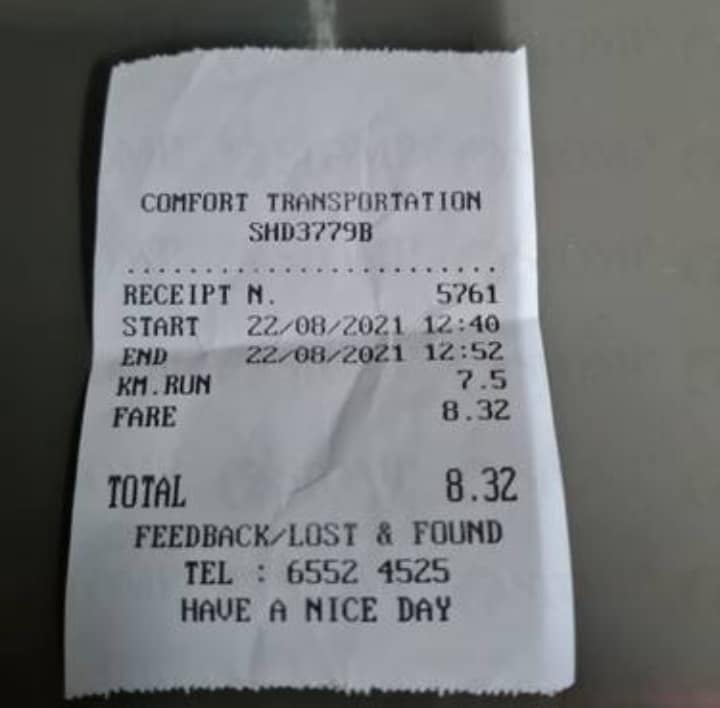

In [27]:
image

## Input Question based on image

In [28]:
question = "What is the total value?"

In [29]:
answer = get_answer(image, question, model, processor)

In [30]:
print(answer)

{'question': 'What is the total value?', 'answer': '8.32'}
